<a href="https://colab.research.google.com/github/dhruvbalwada/enso_prediction_ML/blob/main/ClimateAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting ENSO with neural networks 

El-Nino Southern Oscillation (ENSO) is a dominant pattern (mode) of climate variability in the equatorial Pacific Ocean with a time scale of oscillation on the order of 1-3 years. This signal plays an important role in setting the weather of the earth, in particular the Americas, and thus predicting it can be immensely beneficial for hedging risk in environment related futures (eg. agriculture , fisheries, ski-resorts etc).

Here we will try to train a predictive model that is trained with a section of historic data, and assess its skill on predicting [ENSO index](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/) in some test data. We will train a heirarchy of models, with the simplest starting from a single network neural network, to multiple layers, to CNNs, and finally CNNs+LSTMs. The motivation of increasing compelxity in the models will be given below.

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# load NETCDF4 since it is used by xarray
!pip install netCDF4;

     |████████████████████████████████| 4.3MB 4.9MB/s 
     |████████████████████████████████| 296kB 53.4MB/s 


In [2]:
# download data
# -DB I did this again because I was not able to access the data when I was running the notebook (probably because have different dirs)
# feel free to comment this out.
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

--2020-10-01 21:57:49--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.26, 128.55.206.24
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.26|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc [following]
--2020-10-01 21:57:49--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc’

sst.mon.mean.trefad 100%[===================>] 412.45M  7.82MB/s    in 59s     

2020-10-01 21:58:49 (6.97 MB/s) - ‘sst.mon.mean.trefadj.anom.1880to2018.nc’ saved [432481041/432481041]

In [3]:
data_dir = '/content/'
train_datafile = 'sst.mon.mean.trefadj.anom.1880to2018.nc'
train_labelfile = 'nino34.long.anom.data.txt'

ds = xr.open_dataset(data_dir+train_datafile)

## Description of the dataset 

The data set that will be used for training is the sea-surface temperatures (SST) anomaly at every point on the globe on $1^o X 1^o$ grid, and saved every month. 

SST anomaly means that the data is not the actual temperature, but the temperature where the seasonal cycle has been removed. This is done probably because the ENSO index is defined considering the anomalies from the normal. Where the normal means the seasonal cycle of temperature - ENSO is something that happens in addition to the seasonal cycle and has a magnitude that is small enough that if we just used the full SST, the seasonal cycle would swamp most of the other signals. *In the text below we will use SST as a shorthand, and it is to be understood that we are talking about SST anomaly.*

In [4]:
ds
# the data is now read an xarray Dataset, which has dimensions, coordinates and variables. 
# The nice thing about xarray is that everything lives together in a single container,
# so you can easily access its different parts and also comes with some basic plotting
# capabilities. 

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1668)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-16T12:00:00 ... 2018-12-16T12:00:00
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:              Climate Data Interface version 1.9.6 (http://mpimet.mpg...
    history:          Sun Jun 23 18:30:46 2019: cdo selyear,1880/2018 sst.mon...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    title:            created 12/2013 from data provided by JRA
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    References:       http://www.esrl.noaa.gov/psd/data/gridded/cobe2.html
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    CDO:              Climate Data Operators version 1.9.6 (http://mpimet.mpg...

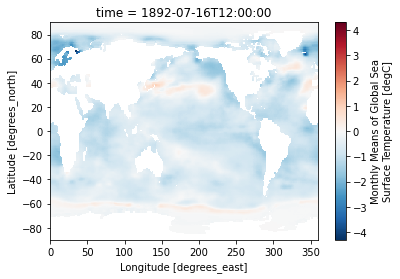

In [5]:
# lets make some plots to see what the data looks like 
ds.sst.isel(time=150).plot()
# you can use isel and sel to select the data. 
# isel requires you to give array index value, so in the above line I am asking 
# to plot the map of SST at time value 0 (note that there are 1668 time values.). 

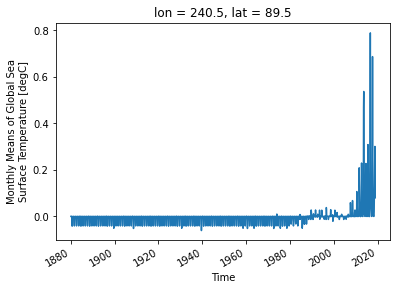

In [6]:
# we can also plot a time series at some point. 
# Use sel when you know the value of the coordinates where you are trying to access the data.
ds.sst.sel(lat=200, lon=240, method='nearest').plot()


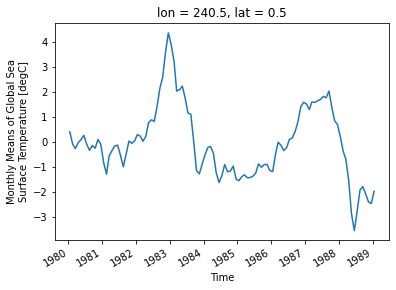

In [7]:
#Note that you could also use sel to access time if you know the dates.
ds.sst.sel(lat=0, lon=240, method='nearest').sel(time=slice("1980-01","1989-01")).plot()


#note that there is no seasonal cycle here because it has been removed. If there was 
# a seasonal cycle you would have seen some sort of oscillations in temperature
# as the sun moved N-S relative to the earth's axis. 

In [ ]:
## Now explore the EN34 index. 

In [8]:
EN34 = pd.read_csv(data_dir+train_labelfile ,header=None)
EN34 
# We could simply readon the ENSO 3.4 index data in using pandas, but this doesn't work so well
# because the data is in a slightly funny format. 
# reading the csv file directly creates this funny file where each row has year 
# number at start, and then 12 numbers following it to represent the monthly
# values. This is the reason why there is the weird function below to read the 
# data, and also assign data to each value. 


,0
0,1870 -1.00 -1.20 -0.83 -0.81 -1.27...
1,1871 -0.25 -0.58 -0.43 -0.50 -0.70...
2,1872 -0.72 -0.62 -0.50 -0.77 -0.62...
3,1873 -0.78 -1.01 -1.31 -0.67 -0.53...
4,1874 -0.93 -1.06 -1.40 -0.94 -0.86...
...,...
145,2015 0.59 0.57 0.48 0.90 1.04...
146,2016 2.56 2.11 1.60 1.05 0.45...
147,2017 -0.34 -0.01 -0.09 0.22 0.30...
148,2018 -0.86 -0.73 -0.73 -0.36 -0.12...


In [9]:
#wrangling the labeled data -DB wrangles ENSO index only here.

def load_enso_indices():
  with open(data_dir+train_labelfile) as f:
    line = f.readline()
    enso_vals = []
    while line:
      yearly_enso_vals = map(float, line.split()[1:])
      
      enso_vals.extend(yearly_enso_vals)
      line = f.readline()
    
  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01', freq='MS', periods=len(enso_vals)) 
  #not sure why you had this set to 1880 (maybe a typo), so I changed it to the actual start data in the .txt file
  enso_vals.index = pd.to_datetime(enso_vals.index)
    
  return enso_vals

In [10]:
EN34_series = load_enso_indices()
EN34_series
# 2019 values are all at -99.99 ..maybe we need to remove the 2019 values?

1870-01-01    -1.00
1870-02-01    -1.20
1870-03-01    -0.83
1870-04-01    -0.81
1870-05-01    -1.27
              ...  
2019-08-01   -99.99
2019-09-01   -99.99
2019-10-01   -99.99
2019-11-01   -99.99
2019-12-01   -99.99
Freq: MS, Length: 1800, dtype: float64

Text(0, 0.5, 'ElNINO3.4')

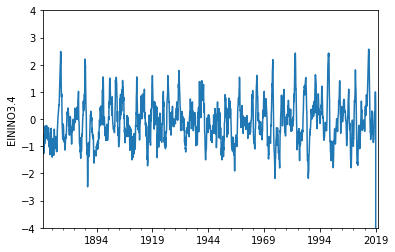

In [11]:
EN34_series.plot() # we can plot pandas series as easily as this too! 
plt.ylim([-4,4])
plt.ylabel('ElNINO3.4')
# Note that we have the index from 1870-2019, 
# while the data for the SST extends from 1880 to 2018 end. 
# We will take care of this discrepancy when making the data set of X and y below. 

## Prepare data sets for ML

In [12]:
# This function does a bunch of things. 
# In particular it re-reads the data sets we read above,
# and picks out the data over the time we want. It also takes
# care of the difference in range of dates between the two data sets. 

def assemble_predictors_predictands(start_date, end_date, lead_time):
  # Read in SST data to create X
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date)) # this sel command selects the data between start and end date
  
  num_time_steps = sst.shape[0]
  sst = sst.values.reshape(num_time_steps, -1)
  
  # -DB read this note about what to do with land points.
  #sst[np.isnan(sst)] = 0 # this step takes care of the land points and just sets them to 0. 
  # If I had to guess, this was done because there is an anticipation that 
  # at some point the 2D matrix will be fed into a CNN. 
  # There are a few alternate ways to do this if we don't care about the full matrix. 
  sst = sst[:,~np.isnan(sst[0,:])] 
  # This removes the land points from the data. 
  # Since we are anyways flattening all the grid points, there is no reason to keep land points. 
  # You can try both ways, and you will see that when the data points are dropped the size
  # is reduced from 64800 to 43799. 

  X = sst
  ds.close() 
  
  # Read in ENSO index to create y. 
  # note that this is the values of the index at "lead_time" months after the X.
  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)

  y = load_enso_indices()[slice(start_date_plus_lead, 
                                end_date_plus_lead)]
  
  return X, y

In [13]:
# function to make plots. 
# Note how he converts predictions to a pandas time series, so the plot can have dates
# on the x-axis
def plot_nino_time_series(y, predictions, title):
  predictions = pd.Series(predictions, index = y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()
  
  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()

In [ ]:
# Function to estimate correlations for each month 
def nino_corr_month(y, predictions):
  predictions = pd.Series(predictions, index = y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()
  
  corr = np.zeros(12)
  for i in range(1,13):
    y1 = y.loc[y.index.month==i]
    y2 = predictions.loc[y.index.month==i]

    corr[i-1], _ = scipy.stats.pearsonr(y1, y2)

  return corr

In [14]:
#load train data and train labels
X, y = assemble_predictors_predictands('1880-01-01', '2005-12-31', 1)
# -DB you could make this train data set much bigger. 
# could try to train from 1880-2010, and then check how well the prediction is for 
# 2011 onwards (following Andrew Ng's advice to have test data sets ~10- 20%).
# could also train in the future (1900-2015) and try to predict for 1880-1900. 

## Build and Train models

We will build, train and compare the following model styles:
- Linear Regression
- Simple Neural Networks
- Convolutional Neural Networks
- LSTMs

We refer to these categories as "model styles", because many subtle choices for each category can lead to very different models. 


### Neural Networks

In [47]:
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow import keras

model = keras.Sequential([#- model DV
                  
                          keras.layers.Flatten(name = 'input_layer', input_shape=(X.shape[1],)),     # -DB had to change the input shape to fix some warnings.                   
                          keras.layers.Dense(200, name = 'hidden_layer_1', activation='relu'),
                          keras.layers.Dropout(0.4), 
                          # keras.layers.Dense(128, name = 'hidden_layer_2', activation='relu'),
                          # keras.layers.Dropout(0.2),
                          keras.layers.Dense(50, name = 'hidden_layer_2', activation='relu'),  
                          #keras.layers.Dropout(0.2),
                          # keras.layers.Dense(32, name = 'hidden_layer_2_2', activation='relu'),  
                          # keras.layers.Dropout(0.2),
                          #keras.layers.Dense(8, name = 'hidden_layer_3', activation='relu'),  
                          keras.layers.Dense(1, name = 'output_layer')                        
                      ])

model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss= tf.keras.losses.mse)
              # metrics = tf.keras.metrics.mse)

# model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss= tf.keras.losses.mse)
#               # metrics = tf.keras.metrics.mse)
          


# -DB Note that because I got rid of the land points, the number of parameters have reduced from 1.3mil to 876K

In [48]:
# -DB Example of how to reset weights. After you have compiled the model the first time, you can save the weights. 
# Then later when training the model multiple times for different lead times, remember to set the weights before starting the training. 
initial_weights = model.get_weights()
model.set_weights(initial_weights)

In [49]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [50]:
print(X.shape)
print(y.shape)

model.summary()


(1512, 43799)
(1512,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Flatten)        (None, 43799)             0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 200)               8760000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 50)                10050     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 51        
Total params: 8,770,101
Trainable params: 8,770,101
Non-trainable params: 0
_________________________________________________________________


In [51]:

#history = model.fit(X, y, epochs=200, batch_size=3, callbacks = [tensorboard_callback])
history = model.fit(X, y, epochs=250, batch_size=2)
# -DB you could vary batch size from 1 to num of timesteps to go from stochastic gradient 
# to mini-batch gradient descent to gradient descent 

# -DB I was just playing around with training data sets and ways to train. So changed some values from what you had. 

Epoch 1/250
756/756 [==============================] - 2s 2ms/step - loss: 0.3110
Epoch 2/250
756/756 [==============================] - 2s 2ms/step - loss: 0.1986
Epoch 3/250
756/756 [==============================] - 2s 2ms/step - loss: 0.1717
Epoch 4/250
756/756 [==============================] - 2s 2ms/step - loss: 0.1554
Epoch 5/250
756/756 [==============================] - 2s 2ms/step - loss: 0.1465
Epoch 6/250
756/756 [==============================] - 2s 2ms/step - loss: 0.1330
Epoch 7/250
756/756 [==============================] - 2s 2ms/step - loss: 0.1234
Epoch 8/250
756/756 [==============================] - 2s 2ms/step - loss: 0.1228
Epoch 9/250
756/756 [==============================] - 2s 2ms/step - loss: 0.1121
Epoch 10/250
756/756 [==============================] - 2s 2ms/step - loss: 0.1009
Epoch 11/250
756/756 [==============================] - 2s 2ms/step - loss: 0.1120
Epoch 12/250
756/756 [==============================] - 2s 2ms/step - loss: 0.0997
Epoch 13/250


KeyboardInterrupt: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

dict_keys(['loss'])


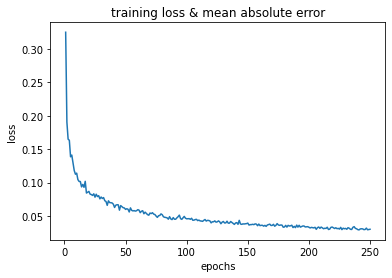

In [52]:
import matplotlib.pyplot as plt

loss = history.history['loss']
#mean_abs_error = history.history['mean_absolute_error']
epochs = range(1, len(loss)+1)

print(history.history.keys())

plt.plot(epochs, loss)
#plt.plot(epochs, mean_abs_error)

plt.xlabel('epochs')
plt.ylabel('loss')

plt.title('training loss & mean absolute error')

plt.show()

In [167]:
X_val, y_val = assemble_predictors_predictands('1990-01-01', '2016-12-31', 1)

# -DB I choose a slight overlap of the test set with the train set, to check how well things
# are fit when we know the answer. This is only for visual comparisons. 
# Make sure that if you are evaluating performance on a test set you remove this overlap. 

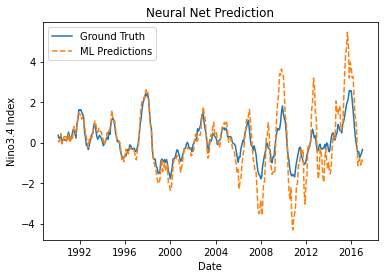

0.8998010589318223


In [168]:
import sklearn.ensemble
import scipy

predictions = model.predict(X_val)
y_hat = predictions.flatten()
plot_nino_time_series(y_val, y_hat, "Neural Net Prediction")

corr, _ = scipy.stats.pearsonr(y_hat, y_val)
print (corr)

# -DB Hard to say if this prediction is good or bad - maybe descent. 
# Atleast seems like the peaks are being captured, but does not do a good job 
# at getting anything under ~+/- 1 right (compare this to the MAE, which is about 0.1 or less).
# This may suggest overfitting. Look at the keras book to see how to evaluate models.


In [66]:
# -DB only run this if setting for the first time
import sklearn.ensemble
import scipy
from tqdm import tqdm

LT = 1
NN_lead_time_to_corr_dict = {}

trained_weights = {}


In [169]:
NN_corr_month = np.zeros((12, 6))

In [171]:
n=0
for LT in tqdm(range(1,13,2)):

  X, y = assemble_predictors_predictands('1880-01-01', '1985-12-31', lead_time=LT) # -DB changed train and val data set in agreement with Ham
  X_val, y_val = assemble_predictors_predictands('1990-01-01', '2016-12-31', lead_time=LT) # -DB: typo fixed, this should be a validation set

  try:
    model.set_weights(trained_weights[LT])
    print('Set older weights - training goes on!')
  except:
    model.set_weights(initial_weights)
    print('Reinitialize weights')
    # - DB set weights to initial values to ensure that when training the next lead time, the old weights are not used. 
    # However, if model has been previously trained then start training from where it was left off. 
  
  model.fit(X, y, epochs=15, batch_size=5, verbose=0) # -DB keep epochs larger if training first time

  predictions = model.predict(X_val)

  y_hat = predictions.flatten()
  corr, _ = scipy.stats.pearsonr(y_hat, y_val)

  NN_lead_time_to_corr_dict[LT] = corr
  NN_corr_month[:,n] = nino_corr_month(y_val, y_hat)
  n=n+1
   # -DB Ideally we should be saving the weights for each model (which in this case just means lead time)
   # So that if you want to play around with a specific model, you should be able reload the weights. 
  trained_weights[LT] = model.get_weights()
  
  print ("Correlation at lead time of " +str(LT) + "months =" +str(corr)) # -DB adjusted printing









  0%|          | 0/6 [00:00<?, ?it/s]

Set older weights - training goes on!









 17%|█▋        | 1/6 [00:09<00:48,  9.77s/it]

Correlation at lead time of 1months =0.9003030743736135
Set older weights - training goes on!









 33%|███▎      | 2/6 [00:19<00:38,  9.71s/it]

Correlation at lead time of 3months =0.8696017149882481
Set older weights - training goes on!









 50%|█████     | 3/6 [00:28<00:28,  9.65s/it]

Correlation at lead time of 5months =0.8455157619549141
Set older weights - training goes on!









 67%|██████▋   | 4/6 [00:38<00:19,  9.62s/it]

Correlation at lead time of 7months =0.6939490930105039
Set older weights - training goes on!









 83%|████████▎ | 5/6 [00:47<00:09,  9.61s/it]

Correlation at lead time of 9months =0.6402222658075744
Set older weights - training goes on!









100%|██████████| 6/6 [00:57<00:00,  9.65s/it]

Correlation at lead time of 11months =0.6471450297694286


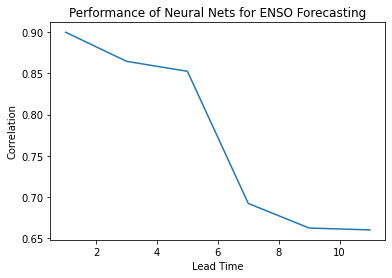

In [157]:
plt.plot(list(NN_lead_time_to_corr_dict.keys()), 
         list(NN_lead_time_to_corr_dict.values()))

plt.title('Performance of Neural Nets for ENSO Forecasting')
plt.xlabel('Lead Time')
plt.ylabel('Correlation')
plt.show()

Text(0.5, 1.0, 'Prediction Skill for NN')

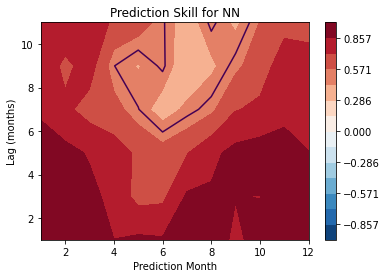

In [172]:
months = np.arange(1,13,1)
LTs = [int(k) for k in NN_lead_time_to_corr_dict.keys()]
plt.contourf(months, LTs, NN_corr_month.T, levels=np.linspace(-1,1, 15), cmap='RdBu_r')
plt.colorbar()
plt.contour(months, LTs, NN_corr_month.T, levels=[.5], )

plt.xlabel('Prediction Month')
plt.ylabel('Lag (months)')
plt.title('Prediction Skill for NN')

## Linear regression model 

This model below seems to work just as well as the neural network above. 

In [54]:
import sklearn.ensemble
import scipy
# SKLEARN is a standard machine learning/statistical modeling library in python
# which has a lot of models built in - many more than just neural networks based.

0.2514641059451517
0.7200434800754618


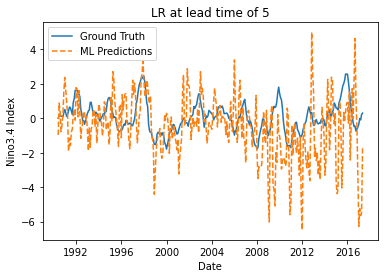

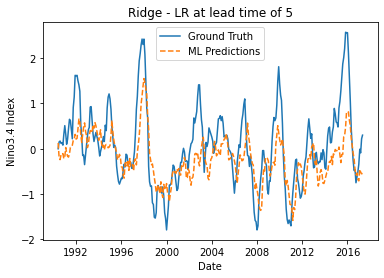

In [108]:
LT=5
X, y = assemble_predictors_predictands('1880-01-01', '1985-12-31', lead_time=LT)
X_val, y_val = assemble_predictors_predictands('1990-01-01','2016-12-31', lead_time=LT) #- DB make sure that validation sets are the same between models (unless you need to change it.)

#linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X, y)
predictions = regr.predict(X_val)
corr_LR, _ = scipy.stats.pearsonr(predictions, y_val)
print (corr_LR)
corr_month_LR = nino_corr_month(y_val, predictions )

# ridge regression model
regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=100000)

regr_1_month_ridge.fit(X, y)
predictions_ridge = regr_1_month_ridge.predict(X_val)
corr_ridge, _ = scipy.stats.pearsonr(predictions_ridge, y_val)
print (corr_ridge)
corr_month_ridge = nino_corr_month(y_val, predictions_ridge)

plot_nino_time_series(y_val, predictions, 'LR at lead time of '+str(LT))
plot_nino_time_series(y_val, predictions_ridge, 'Ridge - LR at lead time of '+str(LT))

# -DB just casually checking I noticed that this model seems to do better if the
# training data is more recent. IF you include a lot of past data (say from 1880), 
# it does worse. 
# This suggests to me that there is some very low frequency signal in the data, 
# which helps short term predictions. 

# -DB notice how it seems like when you do Linear regression, you can get the prediction of 
# the later part of the signal. This is probably because it is easier to predict that when things 
# are high, they will come down. 

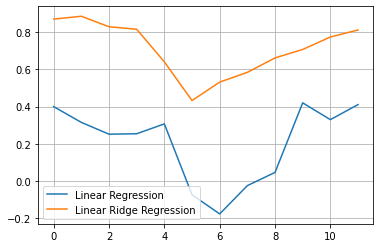

In [111]:
plt.plot(corr_month_LR, label='Linear Regression')
plt.plot(corr_month_ridge, label='Linear Ridge Regression')
plt.legendd()
plt.grid()

In [178]:
from tqdm import tqdm

LRR_lead_time_to_corr_dict = {}
Linear_lead_time_to_corr_dict = {}
LRR_corr_month = np.zeros((12, 6))

n=0
for LT in tqdm(range(1,13,2)):
  X, y = assemble_predictors_predictands('1880-01-01', '1985-12-31', lead_time=LT)
  X_val, y_val = assemble_predictors_predictands('1990-01-01','2016-12-31', lead_time=LT)

  regr = sklearn.linear_model.LinearRegression()
  regr.fit(X,y)

  predictions = regr.predict(X_val)
  corr, _ = scipy.stats.pearsonr(predictions, y_val)
  Linear_lead_time_to_corr_dict[LT] = corr

  regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=100000)

  regr_1_month_ridge.fit(X, y)
  predictions_ridge = regr_1_month_ridge.predict(X_val)
  corr, _ = scipy.stats.pearsonr(predictions_ridge, y_val)
  LRR_lead_time_to_corr_dict[LT] = corr
  LRR_corr_month[:,n] = nino_corr_month(y_val, predictions_ridge)
  n=n+1
  print (corr)









  0%|          | 0/6 [00:00<?, ?it/s]






 17%|█▋        | 1/6 [00:09<00:48,  9.65s/it]

0.9424028827971992









 33%|███▎      | 2/6 [00:19<00:38,  9.62s/it]

0.8411803613873103









 50%|█████     | 3/6 [00:28<00:28,  9.55s/it]

0.7200434800754618









 67%|██████▋   | 4/6 [00:38<00:19,  9.55s/it]

0.6022673790752784









 83%|████████▎ | 5/6 [00:47<00:09,  9.52s/it]

0.5361141889634194









100%|██████████| 6/6 [00:57<00:00,  9.51s/it]

0.4707583545266315


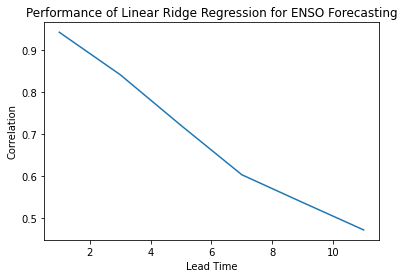

In [153]:
plt.plot(list(LRR_lead_time_to_corr_dict.keys()), 
         list(LRR_lead_time_to_corr_dict.values()))
plt.title('Performance of Linear Ridge Regression for ENSO Forecasting')
plt.xlabel('Lead Time')
plt.ylabel('Correlation')
plt.show()


Text(0.5, 1.0, 'Prediction Skill for LRR')

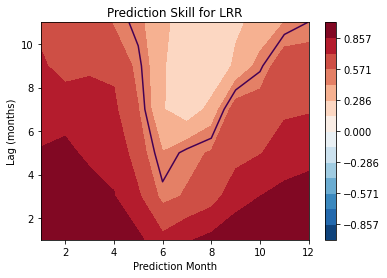

In [154]:
months = np.arange(1,13,1)
LTs = [int(k) for k in LRR_lead_time_to_corr_dict.keys()]
plt.contourf(months, LTs, LRR_corr_month.T, levels=np.linspace(-1,1, 15), cmap='RdBu_r')
plt.colorbar()
plt.contour(months, LTs, LRR_corr_month.T, levels=[.5], )

plt.xlabel('Prediction Month')
plt.ylabel('Lag (months)')
plt.title('Prediction Skill for LRR')

Changing the data set a little bit, I some how managed to get the NN model to do better. However, I am quite skeptical of this. Maybe it would be worth checking how things change if you retrain a little bit, or train for longer (future work leave). 


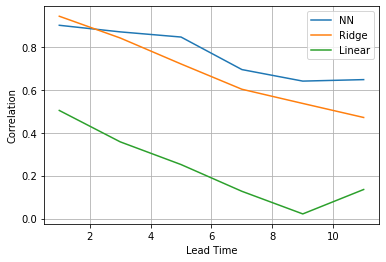

In [180]:
## NN vs LRR 

plt.plot(list(NN_lead_time_to_corr_dict.keys()), 
         list(NN_lead_time_to_corr_dict.values()), label='NN')
plt.plot(list(LRR_lead_time_to_corr_dict.keys()), 
         list(LRR_lead_time_to_corr_dict.values()), label='Ridge')
plt.plot(list(Linear_lead_time_to_corr_dict.keys()), 
         list(Linear_lead_time_to_corr_dict.values()), label='Linear')
plt.grid()
plt.xlabel('Lead Time')
plt.ylabel('Correlation')
plt.legend()
plt.show()


Compare above plot to:
At 6 months the skill of LRR is ~0.65, the NRR is ~0.75 (similar to the black line below). The Ham model and ClimateAI model is beating this "short term" or "sub-seasonal" forecast by having correlation of ~0.9.
![](https://i.imgur.com/gghDrlO.png)

What is the reason for this improvement? 
- better data (leave for future work)
- more sophisticated architecture (can you see how your arbitrary neural network does compared to if you train the Ham model or climateai's model using the same data). 

**Main Task: In the above plot add lines contributing to a CNN (many different options exist, but something like what Ham has might be a good one) and LSTM+CNN. Basically Add lines for CNN and CNN+LSTM models.  **

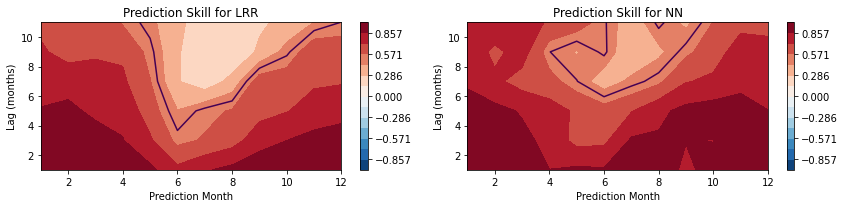

In [177]:
months = np.arange(1,13,1)
LTs = [int(k) for k in NN_lead_time_to_corr_dict.keys()]

plt.figure(figsize=(12,3))

plt.subplot(121)
plt.contourf(months, LTs, LRR_corr_month.T, levels=np.linspace(-1,1, 15), cmap='RdBu_r')
plt.colorbar()
plt.contour(months, LTs, LRR_corr_month.T, levels=[.5], )

plt.xlabel('Prediction Month')
plt.ylabel('Lag (months)')
plt.title('Prediction Skill for LRR')

plt.subplot(122)
plt.contourf(months, LTs, NN_corr_month.T, levels=np.linspace(-1,1, 15), cmap='RdBu_r')
plt.colorbar()
plt.contour(months, LTs, NN_corr_month.T, levels=[.5], )

plt.xlabel('Prediction Month')
plt.ylabel('Lag (months)')
plt.title('Prediction Skill for NN')

plt.tight_layout()

## - DB the simple neural network has managed to push the predictability skill out slightly. 

## Things to check with above models. 
- How does the prediction skill on the test data change as lead time is changed? **CHECKED**
- Check prediction skill for different months 


**Model architecture effects (leave out, if it is too much work for now)**
- How does the prediction skill depend on number of layers?
- How does the prediction skill depend on the size of these layers? 

Can these previous 2 questions be answered in some systematic way? (probably can google this to figure out, one suggestion off the top of my head it to make a contour plot of error in test set with nlayers on x axis and some meausure of the width of the dense layers.

It also seems to me that having a smaller network actually give more skill since you don't really have a lot of data to train with.

Obviously we want the prediction to work well for longer lead time. See if you can beat this curve for linear regress (from Mahesh's notebook) -- **!!! Looks like you beat his linear rigression with linear ridge regression and neural networks !!**
![](https://i.imgur.com/myQeWWf.png)

## CNNs 

Since linear regression and simple neural networks did not do great, we now move to using CNNs.
...

In [ ]:
def assemble_predictors_predictands_cnn(start_date, end_date, lead_time, method):
  # Read in SST data to create X
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date)) # this sel command selects the data between start and end date
  
  num_time_steps = sst.shape[0]
  if method == 'cnn':
    sst = sst.values.reshape(num_time_steps, 180, 360, 1)
  
  if method == 'rnn':
    sst = sst.values.reshape(num_time_steps, 1,  180, 360, 1)
  #sst = sst.values.reshape(num_time_steps, 1,  180, 360, 1)
  #sst = sst[:,~np.isnan(sst[0,:]), ~np.isnan(sst[0,:]),:] 
  sst[np.isnan(sst)] = 0
  # This removes the land points from the data. 
  # Since we are anyways flattening all the grid points, there is no reason to keep land points. 
  # You can try both ways, and you will see that when the data points are dropped the size
  # is reduced from 64800 to 43799. 

  X = sst
  ds.close() 
  
  # Read in ENSO index to create y. 
  # note that this is the values of the index at "lead_time" months after the X.
  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)

  y = load_enso_indices()[slice(start_date_plus_lead, 
                                end_date_plus_lead)]
  
  return X, y

In [ ]:
X, y = assemble_predictors_predictands_cnn('1880-01-01', '2005-12-31', 1, 'cnn')
print (X.shape)
print (y.shape)

(1512, 180, 360, 1)
(1512,)


In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
                          keras.layers.Conv2D(50, kernel_size = (8, 4), activation = 'tanh', input_shape = (180,360,1)),
                          keras.layers.MaxPooling2D((2,2)),
                          keras.layers.BatchNormalization(),
                          keras.layers.Conv2D(50, (4, 2), name = 'conv_layer2', activation = 'tanh'),
                          keras.layers.MaxPooling2D(2, 2),
                          keras.layers.BatchNormalization(),
                          keras.layers.Conv2D(50, (4,2), activation='tanh')
                         # keras.layers.MaxPooling2D(2,2),
                         # keras.layers.BatchNormalization(),                                      
])

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.4))
#model.add(keras.layers.Dense(16, activation= 'relu'))
model.add(keras.layers.Dense(50, activation= 'tanh'))
model.add(keras.layers.Dense(1, name = 'output_layer'))

model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001),
              loss= tf.keras.losses.mse)
model.summary()           

In [ ]:
history = model.fit(X, y, epochs=20, batch_size=2)

In [ ]:
X_test, y_test = assemble_predictors_predictands_cnn('2008-01-01', '2015-12-31', 1, 'cnn')

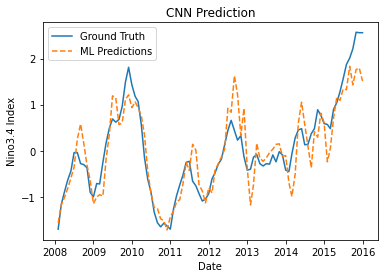

0.895312456024795


In [ ]:
predictions = model.predict(X_test)
y_hat = predictions.flatten()

plot_nino_time_series(y_test, y_hat, "CNN Prediction")

import sklearn.ensemble
import scipy

corr2, _ = scipy.stats.pearsonr(y_hat, y_test)
print (corr2)

### Visualizing CNN layers

In [ ]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_test)
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='coolwarm')
            activation_index += 1

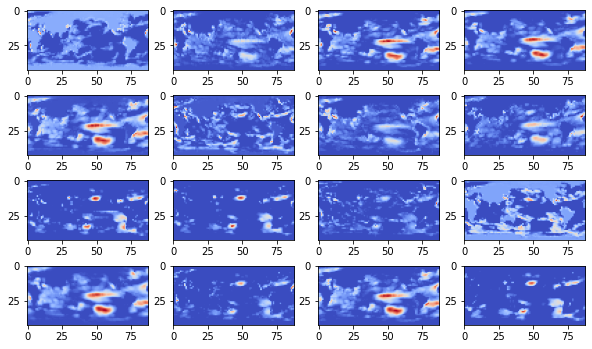

In [ ]:
display_activation(activations, 4, 4, 5)

## CNN + LSTM

In [ ]:
X, y = assemble_predictors_predictands_cnn('1960-01-01', '2005-12-31', 1, 'rnn')
print (X.shape)

(552, 1, 180, 360, 1)


In [ ]:
#from keras.models import Sequential, Model, load_model, model_from_json
model = keras.Sequential([
                          keras.layers.ConvLSTM2D(16, kernel_size = (3,3), activation = 'tanh', input_shape = (X.shape[0],180,360,1))                    
                       #   keras.layers.MaxPooling2D((2,2)),
                        #  keras.layers.BatchNormalization()
                                               
])
model.add(keras.layers.Flatten())
#model.add(keras.layers.LSTM(10, return_sequences=False, input_shape = (180, 360)))

# model.add(keras.layers.LSTM(units = 10))
# model.add(keras.layers.Dropout(0.4))
#model.add(keras.layers.Dense(16, activation= 'relu'))
model.add(keras.layers.Dense(5, activation= 'relu'))
model.add(keras.layers.Dense(1, name = 'output_layer'))

model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss= tf.keras.losses.mse)
model.summary()

In [ ]:
from keras.models import Sequential


model = Sequential()
model.add(keras.layers.ConvLSTM2D(16, (3,3), return_sequences=True, input_shape=(None, 180, 360, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv3D(1, (3,3,3), activation = 'linear', data_format='channels_last'))

model.summary()




Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_19 (ConvLSTM2D) (None, None, 178, 358, 16 9856      
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 178, 358, 16 64        
_________________________________________________________________
conv3d_8 (Conv3D)            (None, None, 176, 356, 1) 433       
Total params: 10,353
Trainable params: 10,321
Non-trainable params: 32
_________________________________________________________________


In [ ]:
model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss= tf.keras.losses.mse)

model.fit(X, y, epochs = 10, batch_size = 2)


Epoch 1/10


ValueError: ignored

In [ ]:
X_test, y_test = assemble_predictors_predictands_cnn('2008-01-01', '2015-12-31', 6, 'rnn')

NameError: ignored

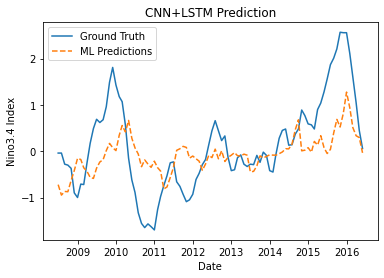

0.5928433063601165


In [ ]:
predictions = model.predict(X_test)
y_hat = predictions.flatten()

plot_nino_time_series(y_test, y_hat, "CNN+LSTM Prediction")

import sklearn.ensemble
import scipy

corr2, _ = scipy.stats.pearsonr(y_hat, y_test)
print (corr2)